# Get started with the Gemini API: Python

In [5]:
# !pip install -q -U google-generativeai

### Import packages

Import the necessary packages.

In [8]:
import pathlib
import textwrap

import google.generativeai as genai

from IPython.display import display
from IPython.display import Markdown


def to_markdown(text):
  text = text.replace('•', '  *')
  return Markdown(textwrap.indent(text, '> ', predicate=lambda _: True))

### Setup your API key

Before you can use the Gemini API, you must first obtain an API key. If you don't already have one, create a key with one click in Google AI Studio.

<a class="button button-primary" href="https://makersuite.google.com/app/apikey" target="_blank" rel="noopener noreferrer">Get an API key</a>

In Colab, add the key to the secrets manager under the "🔑" in the left panel. Give it the name `GOOGLE_API_KEY`.

Once you have the API key, pass it to the SDK. You can do this in two ways:

* Put the key in the `GOOGLE_API_KEY` environment variable (the SDK will automatically pick it up from there).
* Pass the key to `genai.configure(api_key=...)`

In [9]:
# Or use `os.getenv('GOOGLE_API_KEY')` to fetch an environment variable.
# GOOGLE_API_KEY=userdata.get('GOOGLE_API_KEY')

genai.configure(api_key="")

## List models

Now you're ready to call the Gemini API. Use `list_models` to see the available Gemini models:

* `gemini-pro`: optimized for text-only prompts.
* `gemini-pro-vision`: optimized for text-and-images prompts.

In [10]:
for m in genai.list_models():
  if 'generateContent' in m.supported_generation_methods:
    print(m.name)

models/gemini-1.0-pro
models/gemini-1.0-pro-001
models/gemini-1.0-pro-latest
models/gemini-1.0-pro-vision-latest
models/gemini-1.5-flash-latest
models/gemini-1.5-pro-latest
models/gemini-pro
models/gemini-pro-vision


### Generate text from image and text inputs

Gemini provides a multimodal model (`gemini-pro-vision`) that accepts both text and images and inputs. The `GenerativeModel.generate_content` API is designed to handle multimodal prompts and returns a text output.

Let's include an image:

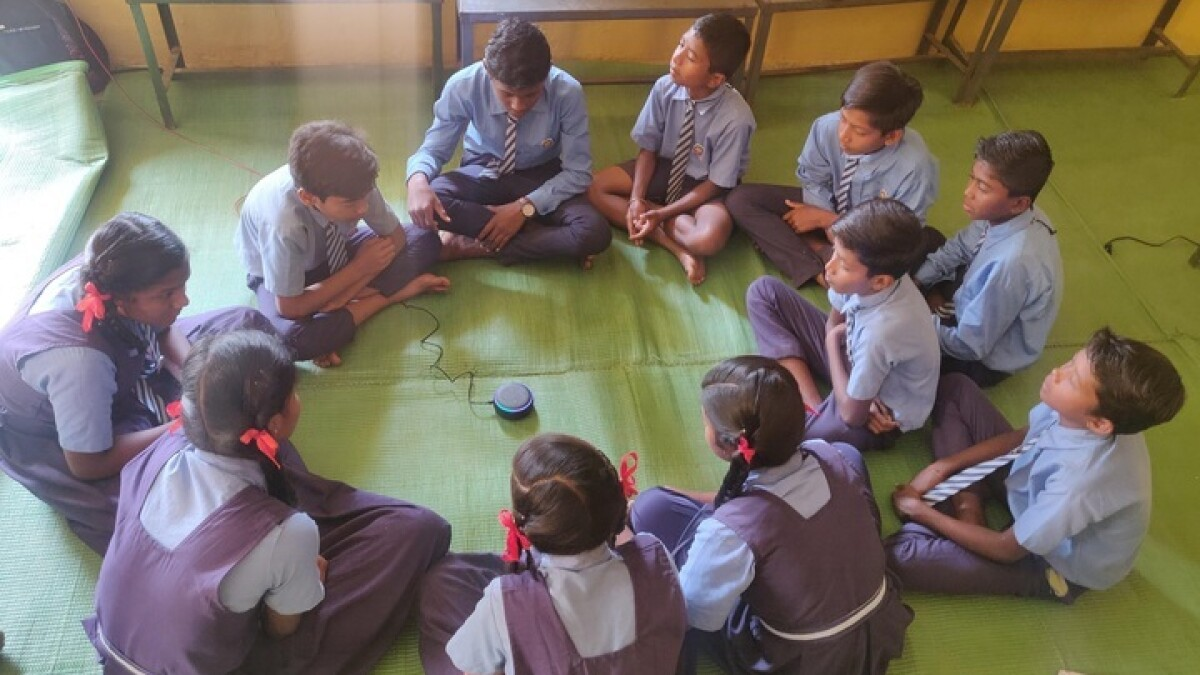

In [15]:
import PIL.Image

img = PIL.Image.open('data/classroom_1.png')
img

To provide both text and images in a prompt, pass a list containing the strings and images:

In [16]:
model = genai.GenerativeModel('gemini-pro-vision')
response = model.generate_content(["You are very good at counting. Carefully count the number of children you can find in the image.", img])
response.resolve()
to_markdown(response.text)

>  There are 10 children.

In [17]:
model = genai.GenerativeModel('gemini-1.5-flash-latest')
response = model.generate_content(["You are very good at counting. Carefully count the number of children you can find in the image.", img])
response.resolve()
to_markdown(response.text)

> There are 9 children in the image.

In [24]:
model = genai.GenerativeModel('gemini-1.5-pro-latest')
response = model.generate_content(["Carefully count the number of children you can find in the image.", img])
response.resolve()
to_markdown(response.text)

> There are **11** children in the image. 


## Chat conversations

Gemini enables you to have freeform conversations across multiple turns. The `ChatSession` class simplifies the process by managing the state of the conversation, so unlike with `generate_content`, you do not have to store the conversation history as a list.

Initialize the chat:

In [ ]:
model = genai.GenerativeModel('gemini-pro')
chat = model.start_chat(history=[])
chat

Note: The vision model `gemini-pro-vision` is not optimized for multi-turn chat.

The `ChatSession.send_message` method returns the same `GenerateContentResponse` type as <a href="https://ai.google.dev/api/python/google/generativeai/GenerativeModel#generate_content"><code>GenerativeModel.generate_content</code></a>. It also appends your message and the response to the chat history:

In [ ]:
response = chat.send_message("In one sentence, explain how a computer works to a young child.")
to_markdown(response.text)

> A computer is like a very smart machine that can understand and follow our instructions, help us with our work, and even play games with us!

In [ ]:
chat.history

[parts {
   text: "In one sentence, explain how a computer works to a young child."
 }
 role: "user",
 parts {
   text: "A computer is like a very smart machine that can understand and follow our instructions, help us with our work, and even play games with us!"
 }
 role: "model"]

You can keep sending messages to continue the conversation. Use the `stream=True` argument to stream the chat:

In [ ]:
response = chat.send_message("Okay, how about a more detailed explanation to a high schooler?", stream=True)

for chunk in response:
  print(chunk.text)
  print("_"*80)

A computer works by following instructions, called a program, which tells it what to
________________________________________________________________________________
 do. These instructions are written in a special language that the computer can understand, and they are stored in the computer's memory. The computer's processor
________________________________________________________________________________
, or CPU, reads the instructions from memory and carries them out, performing calculations and making decisions based on the program's logic. The results of these calculations and decisions are then displayed on the computer's screen or stored in memory for later use.

To give you a simple analogy, imagine a computer as a
________________________________________________________________________________
 chef following a recipe. The recipe is like the program, and the chef's actions are like the instructions the computer follows. The chef reads the recipe (the program) and performs act

`glm.Content` objects contain a list of `glm.Part` objects that each contain either a text (string) or inline_data (`glm.Blob`), where a blob contains binary data and a `mime_type`. The chat history is available as a list of `glm.Content` objects in `ChatSession.history`:

In [ ]:
for message in chat.history:
  display(to_markdown(f'**{message.role}**: {message.parts[0].text}'))

> **user**: In one sentence, explain how a computer works to a young child.

> **model**: A computer is like a very smart machine that can understand and follow our instructions, help us with our work, and even play games with us!

> **user**: Okay, how about a more detailed explanation to a high schooler?

> **model**: A computer works by following instructions, called a program, which tells it what to do. These instructions are written in a special language that the computer can understand, and they are stored in the computer's memory. The computer's processor, or CPU, reads the instructions from memory and carries them out, performing calculations and making decisions based on the program's logic. The results of these calculations and decisions are then displayed on the computer's screen or stored in memory for later use.
> 
> To give you a simple analogy, imagine a computer as a chef following a recipe. The recipe is like the program, and the chef's actions are like the instructions the computer follows. The chef reads the recipe (the program) and performs actions like gathering ingredients (fetching data from memory), mixing them together (performing calculations), and cooking them (processing data). The final dish (the output) is then presented on a plate (the computer screen).
> 
> In summary, a computer works by executing a series of instructions, stored in its memory, to perform calculations, make decisions, and display or store the results.

## Count tokens

Large language models have a context window, and the context length is often measured in terms of the **number of tokens**. With the Gemini API, you can determine the number of tokens per any `glm.Content` object. In the simplest case, you can pass a query string to the `GenerativeModel.count_tokens` method as follows:

In [ ]:
model.count_tokens("What is the meaning of life?")

total_tokens: 7

Similarly, you can check `token_count` for your `ChatSession`:

In [ ]:
model.count_tokens(chat.history)

total_tokens: 501

## Use embeddings

[Embedding](https://developers.google.com/machine-learning/glossary#embedding-vector) is a technique used to represent information as a list of floating point numbers in an array. With Gemini, you can represent text (words, sentences, and blocks of text) in a vectorized form, making it easier to compare and contrast embeddings. For example, two texts that share a similar subject matter or sentiment should have similar embeddings, which can be identified through mathematical comparison techniques such as cosine similarity. For more on how and why you should use embeddings, refer to the [Embeddings guide](https://ai.google.dev/docs/embeddings_guide).

Use the `embed_content` method to generate embeddings. The method handles embedding for the following tasks (`task_type`):

Task Type | Description
---       | ---
RETRIEVAL_QUERY	| Specifies the given text is a query in a search/retrieval setting.
RETRIEVAL_DOCUMENT | Specifies the given text is a document in a search/retrieval setting. Using this task type requires a `title`.
SEMANTIC_SIMILARITY	| Specifies the given text will be used for Semantic Textual Similarity (STS).
CLASSIFICATION	| Specifies that the embeddings will be used for classification.
CLUSTERING	| Specifies that the embeddings will be used for clustering.

The following generates an embedding for a single string for document retrieval:

In [ ]:
result = genai.embed_content(
    model="models/embedding-001",
    content="What is the meaning of life?",
    task_type="retrieval_document",
    title="Embedding of single string")

# 1 input > 1 vector output
print(str(result['embedding'])[:50], '... TRIMMED]')

[-0.003216741, -0.013358698, -0.017649598, -0.0091 ... TRIMMED]


Note: The `retrieval_document` task type is the only task that accepts a title.

To handle batches of strings, pass a list of strings in `content`:

In [ ]:
result = genai.embed_content(
    model="models/embedding-001",
    content=[
      'What is the meaning of life?',
      'How much wood would a woodchuck chuck?',
      'How does the brain work?'],
    task_type="retrieval_document",
    title="Embedding of list of strings")

# A list of inputs > A list of vectors output
for v in result['embedding']:
  print(str(v)[:50], '... TRIMMED ...')

[0.0040260437, 0.004124458, -0.014209415, -0.00183 ... TRIMMED ...
[-0.004049845, -0.0075574904, -0.0073463684, -0.03 ... TRIMMED ...
[0.025310587, -0.0080734305, -0.029902633, 0.01160 ... TRIMMED ...


While the `genai.embed_content` function accepts simple strings or lists of strings, it is actually built around the `glm.Content` type (like <a href="https://ai.google.dev/api/python/google/generativeai/GenerativeModel#generate_content"><code>GenerativeModel.generate_content</code></a>). `glm.Content` objects are the primary units of conversation in the API.

While the `glm.Content` object is multimodal, the `embed_content` method only supports text embeddings. This design gives the API the *possibility* to expand to multimodal embeddings.

In [ ]:
response.candidates[0].content

parts {
  text: "A computer works by following instructions, called a program, which tells it what to do. These instructions are written in a special language that the computer can understand, and they are stored in the computer\'s memory. The computer\'s processor, or CPU, reads the instructions from memory and carries them out, performing calculations and making decisions based on the program\'s logic. The results of these calculations and decisions are then displayed on the computer\'s screen or stored in memory for later use.\n\nTo give you a simple analogy, imagine a computer as a chef following a recipe. The recipe is like the program, and the chef\'s actions are like the instructions the computer follows. The chef reads the recipe (the program) and performs actions like gathering ingredients (fetching data from memory), mixing them together (performing calculations), and cooking them (processing data). The final dish (the output) is then presented on a plate (the computer screen

In [ ]:
result = genai.embed_content(
    model = 'models/embedding-001',
    content = response.candidates[0].content)

# 1 input > 1 vector output
print(str(result['embedding'])[:50], '... TRIMMED ...')

[-0.013921871, -0.03504407, -0.0051786783, 0.03113 ... TRIMMED ...


Similarly, the chat history contains a list of `glm.Content` objects, which you can pass directly to the `embed_content` function:

In [ ]:
chat.history

[parts {
   text: "In one sentence, explain how a computer works to a young child."
 }
 role: "user",
 parts {
   text: "A computer is like a very smart machine that can understand and follow our instructions, help us with our work, and even play games with us!"
 }
 role: "model",
 parts {
   text: "Okay, how about a more detailed explanation to a high schooler?"
 }
 role: "user",
 parts {
   text: "A computer works by following instructions, called a program, which tells it what to do. These instructions are written in a special language that the computer can understand, and they are stored in the computer\'s memory. The computer\'s processor, or CPU, reads the instructions from memory and carries them out, performing calculations and making decisions based on the program\'s logic. The results of these calculations and decisions are then displayed on the computer\'s screen or stored in memory for later use.\n\nTo give you a simple analogy, imagine a computer as a chef following a reci

In [ ]:
result = genai.embed_content(
    model = 'models/embedding-001',
    content = chat.history)

# 1 input > 1 vector output
for i,v in enumerate(result['embedding']):
  print(str(v)[:50], '... TRIMMED...')

[-0.014632266, -0.042202696, -0.015757175, 0.01548 ... TRIMMED...
[-0.010979066, -0.024494737, 0.0092659835, 0.00803 ... TRIMMED...
[-0.010055617, -0.07208932, -0.00011750793, -0.023 ... TRIMMED...
[-0.013921871, -0.03504407, -0.0051786783, 0.03113 ... TRIMMED...


## Advanced use cases

The following sections discuss advanced use cases and lower-level details of the Python SDK for the Gemini API.

### Safety settings

The `safety_settings` argument lets you configure what the model blocks and allows in both prompts and responses. By default, safety settings block content with medium and/or high probability of being unsafe content across all dimensions. Learn more about [Safety settings](https://ai.google.dev/docs/safety_setting).

Enter a questionable prompt and run the model with the default safety settings, and it will not return any candidates:

In [ ]:
response = model.generate_content('[Questionable prompt here]')
response.candidates

[content {
  parts {
    text: "I\'m sorry, but this prompt involves a sensitive topic and I\'m not allowed to generate responses that are potentially harmful or inappropriate."
  }
  role: "model"
}
finish_reason: STOP
index: 0
safety_ratings {
  category: HARM_CATEGORY_SEXUALLY_EXPLICIT
  probability: NEGLIGIBLE
}
safety_ratings {
  category: HARM_CATEGORY_HATE_SPEECH
  probability: NEGLIGIBLE
}
safety_ratings {
  category: HARM_CATEGORY_HARASSMENT
  probability: NEGLIGIBLE
}
safety_ratings {
  category: HARM_CATEGORY_DANGEROUS_CONTENT
  probability: NEGLIGIBLE
}
]

The `prompt_feedback` will tell you which safety filter blocked the prompt:

In [ ]:
response.prompt_feedback

safety_ratings {
  category: HARM_CATEGORY_SEXUALLY_EXPLICIT
  probability: NEGLIGIBLE
}
safety_ratings {
  category: HARM_CATEGORY_HATE_SPEECH
  probability: NEGLIGIBLE
}
safety_ratings {
  category: HARM_CATEGORY_HARASSMENT
  probability: NEGLIGIBLE
}
safety_ratings {
  category: HARM_CATEGORY_DANGEROUS_CONTENT
  probability: NEGLIGIBLE
}

Now provide the same prompt to the model with newly configured safety settings, and you may get a response.

In [ ]:
response = model.generate_content('[Questionable prompt here]',
                                  safety_settings={'HARASSMENT':'block_none'})
response.text

Also note that each candidate has its own `safety_ratings`, in case the prompt passes but the individual responses fail the safety checks.

### Encode messages

The previous sections relied on the SDK to make it easy for you to send prompts to the API. This section offers a fully-typed equivalent to the previous example, so you can better understand the lower-level details regarding how the SDK encodes messages.

Underlying the Python SDK is the <a href="https://ai.google.dev/api/python/google/ai/generativelanguage"><code>google.ai.generativelanguage</code></a> client library:

In [ ]:
import google.ai.generativelanguage as glm

The SDK attempts to convert your message to a `glm.Content` object, which contains a list of `glm.Part` objects that each contain either:

1. a <a href="https://www.tensorflow.org/text/api_docs/python/text"><code>text</code></a> (string)
2. `inline_data` (`glm.Blob`), where a blob contains binary `data` and a `mime_type`.

You can also pass any of these classes as an equivalent dictionary.

Note: The only accepted mime types are some image types, `image/*`.

So, the fully-typed equivalent to the previous example is:  

In [ ]:
model = genai.GenerativeModel('gemini-pro-vision')
response = model.generate_content(
    glm.Content(
        parts = [
            glm.Part(text="Write a short, engaging blog post based on this picture."),
            glm.Part(
                inline_data=glm.Blob(
                    mime_type='image/jpeg',
                    data=pathlib.Path('image.jpg').read_bytes()
                )
            ),
        ],
    ),
    stream=True)

In [ ]:
response.resolve()

to_markdown(response.text[:100] + "... [TRIMMED] ...")

>  Meal prepping is a great way to save time and money, and it can also help you to eat healthier. By ... [TRIMMED] ...

### Multi-turn conversations

While the `genai.ChatSession` class shown earlier can handle many use cases, it does make some assumptions. If your use case doesn't fit into this chat implementation it's good to remember that `genai.ChatSession` is just a wrapper around <a href="https://ai.google.dev/api/python/google/generativeai/GenerativeModel#generate_content"><code>GenerativeModel.generate_content</code></a>. In addition to single requests, it can handle multi-turn conversations.

The individual messages are `glm.Content` objects or compatible dictionaries, as seen in previous sections. As a dictionary, the message requires `role` and `parts` keys. The `role` in a conversation can either be the `user`, which provides the prompts, or `model`, which provides the responses.

Pass a list of `glm.Content` objects and it will be treated as multi-turn chat:

In [ ]:
model = genai.GenerativeModel('gemini-pro')

messages = [
    {'role':'user',
     'parts': ["Briefly explain how a computer works to a young child."]}
]
response = model.generate_content(messages)

to_markdown(response.text)

> Imagine a computer as a really smart friend who can help you with many things. Just like you have a brain to think and learn, a computer has a brain too, called a processor. It's like the boss of the computer, telling it what to do.
> 
> Inside the computer, there's a special place called memory, which is like a big storage box. It remembers all the things you tell it to do, like opening games or playing videos.
> 
> When you press buttons on the keyboard or click things on the screen with the mouse, you're sending messages to the computer. These messages travel through special wires, called cables, to the processor.
> 
> The processor reads the messages and tells the computer what to do. It can open programs, show you pictures, or even play music for you.
> 
> All the things you see on the screen are created by the graphics card, which is like a magic artist inside the computer. It takes the processor's instructions and turns them into colorful pictures and videos.
> 
> To save your favorite games, videos, or pictures, the computer uses a special storage space called a hard drive. It's like a giant library where the computer can keep all your precious things safe.
> 
> And when you want to connect to the internet to play games with friends or watch funny videos, the computer uses something called a network card to send and receive messages through the internet cables or Wi-Fi signals.
> 
> So, just like your brain helps you learn and play, the computer's processor, memory, graphics card, hard drive, and network card all work together to make your computer a super-smart friend that can help you do amazing things!

To continue the conversation, add the response and another message.

Note: For multi-turn conversations, you need to send the whole conversation history with each request. The API is **stateless**.

In [ ]:
messages.append({'role':'model',
                 'parts':[response.text]})

messages.append({'role':'user',
                 'parts':["Okay, how about a more detailed explanation to a high school student?"]})

response = model.generate_content(messages)

to_markdown(response.text)

> At its core, a computer is a machine that can be programmed to carry out a set of instructions. It consists of several essential components that work together to process, store, and display information:
> 
> **1. Processor (CPU):**
>    - The brain of the computer.
>    - Executes instructions and performs calculations.
>    - Speed measured in gigahertz (GHz).
>    - More GHz generally means faster processing.
> 
> **2. Memory (RAM):**
>    - Temporary storage for data being processed.
>    - Holds instructions and data while the program is running.
>    - Measured in gigabytes (GB).
>    - More GB of RAM allows for more programs to run simultaneously.
> 
> **3. Storage (HDD/SSD):**
>    - Permanent storage for data.
>    - Stores operating system, programs, and user files.
>    - Measured in gigabytes (GB) or terabytes (TB).
>    - Hard disk drives (HDDs) are traditional, slower, and cheaper.
>    - Solid-state drives (SSDs) are newer, faster, and more expensive.
> 
> **4. Graphics Card (GPU):**
>    - Processes and displays images.
>    - Essential for gaming, video editing, and other graphics-intensive tasks.
>    - Measured in video RAM (VRAM) and clock speed.
> 
> **5. Motherboard:**
>    - Connects all the components.
>    - Provides power and communication pathways.
> 
> **6. Input/Output (I/O) Devices:**
>    - Allow the user to interact with the computer.
>    - Examples: keyboard, mouse, monitor, printer.
> 
> **7. Operating System (OS):**
>    - Software that manages the computer's resources.
>    - Provides a user interface and basic functionality.
>    - Examples: Windows, macOS, Linux.
> 
> When you run a program on your computer, the following happens:
> 
> 1. The program instructions are loaded from storage into memory.
> 2. The processor reads the instructions from memory and executes them one by one.
> 3. If the instruction involves calculations, the processor performs them using its arithmetic logic unit (ALU).
> 4. If the instruction involves data, the processor reads or writes to memory.
> 5. The results of the calculations or data manipulation are stored in memory.
> 6. If the program needs to display something on the screen, it sends the necessary data to the graphics card.
> 7. The graphics card processes the data and sends it to the monitor, which displays it.
> 
> This process continues until the program has completed its task or the user terminates it.

### Generation configuration

The `generation_config` argument allows you to modify the generation parameters. Every prompt you send to the model includes parameter values that control how the model generates responses.

In [ ]:
model = genai.GenerativeModel('gemini-pro')
response = model.generate_content(
    'Tell me a story about a magic backpack.',
    generation_config=genai.types.GenerationConfig(
        # Only one candidate for now.
        candidate_count=1,
        stop_sequences=['x'],
        max_output_tokens=20,
        temperature=1.0)
)

In [ ]:
text = response.text

if response.candidates[0].finish_reason.name == "MAX_TOKENS":
    text += '...'

to_markdown(text)

> Once upon a time, in a small town nestled amidst lush green hills, lived a young girl named...

## What's next

-   Prompt design is the process of creating prompts that elicit the desired response from language models. Writing well structured prompts is an essential part of ensuring accurate, high quality responses from a language model. Learn about best practices for [prompt writing](https://ai.google.dev/docs/prompt_best_practices).
-   Gemini offers several model variations to meet the needs of different use cases, such as input types and complexity, implementations for chat or other dialog language tasks, and size constraints. Learn about the available [Gemini models](https://ai.google.dev/models/gemini).
-   Gemini offers options for requesting [rate limit increases](https://ai.google.dev/docs/increase_quota). The rate limit for Gemini-Pro models is 60 requests per minute (RPM).